# Application of machine learning to the prediction of NHL players pts/gm
*By Samuel Mercier, March 2018*

The following is a simple tutorial showing how to predict the number of points per game of NHL players from the statistics they have obtained during the previous season. The script includes the extraction of players statistics from NHL.com, data cleaning and preprocessing, training/testing of a neural network using TensorFlow, and the analysis of the results.

First, let's make our imports!

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from sklearn import preprocessing
import tensorflow as tf

We will extract the data required to train the neural network from NHL.com. We will consider players statistics beginning at the 2005-2006 season (post-lockout era). On NHL.com, the statsitics are split between different categories - the url to extract these statistics are the following:

In [3]:
URL_dictionnary = {        
    'summary': "http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=basic&isGame=false&reportName=skatersummary&sort=[{%22property%22:%22points%22,%22direction%22:%22DESC%22},{%22property%22:%22goals%22,%22direction%22:%22DESC%22},{%22property%22:%22assists%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20052006%20and%20seasonId%3C=20172018",
        
    'hits': "http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=basic&isGame=false&reportName=realtime&sort=[{%22property%22:%22hits%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20052006%20and%20seasonId%3C=20172018",
        
    'TOI': "http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=basic&isGame=false&reportName=timeonice&sort=[{%22property%22:%22timeOnIce%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20052006%20and%20seasonId%3C=20172018",
        
    'plusminus': "http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=basic&isGame=false&reportName=plusminus&sort=[{%22property%22:%22plusMinus%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20052006%20and%20seasonId%3C=20172018",
        
    'shots': "http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=shooting&isGame=false&reportName=skaterpercentages&sort=[{%22property%22:%22shotAttemptsPctg%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20052006%20and%20seasonId%3C=20172018", 
        
    'faceoff': "http://www.nhl.com/stats/rest/skaters?isAggregate=false&reportType=core&isGame=false&reportName=faceoffsbyzone&sort=[{%22property%22:%22faceoffWins%22,%22direction%22:%22DESC%22}]&cayenneExp=gameTypeId=2%20and%20seasonId%3E=20052006%20and%20seasonId%3C=20172018"
        }

Let's first create a function to extract the statistics from the Website. In this function, we loop through the urls in the URL dictionary, load the data (which is in a json format), and store it in a dataframe using Pandas. All statistics are merged in a single data frame, with the index of each entry being the name of the player concatenated with the season when the statistics have been obtained.

In [4]:
def extract_data_from_website(extract_to_csv=False):
    #The data are extracted to a pandas dataframe
    df_all_stats = pd.DataFrame()
    #Loop through the urls in URL_dictionnary
    for name, url in URL_dictionnary.items():
        try:
            # Request and extract the data
            blob = requests.get(url).content
            json_data = json.loads(blob)['data']
            # Place in a dataframe
            df = pd.DataFrame(json_data)
            # Use the player name and the season as the index
            df['name_seasons_id'] = df['playerName'].map(str) + '_' + df['seasonId'].map(str)
            df = df.set_index('name_seasons_id')
            # Merge all the data in a single dataframe
            new_columns = df.columns.difference(df_all_stats.columns)
            df_all_stats = pd.merge(df_all_stats, df[new_columns], how='outer',
                                    left_index=True,right_index=True)
        
        #indicate if there is an error
        except Exception as e:
            print('Did not work for', name, ' because of', e)
    
    #Optionally, save the data to a csv if we want to use it again in the future
    if extract_to_csv:
        df_all_stats.to_csv('nhl_data.csv')
    
    return df_all_stats    

We can run the function, and confirm that our data look as expected

In [5]:
df_all_stats = extract_data_from_website()
#Let's look at the first 20 entries
df_all_stats.head(20)

,assists,faceoffWinPctg,gameWinningGoals,gamesPlayed,goals,otGoals,penaltyMinutes,playerBirthCity,playerBirthCountry,playerBirthDate,...,faceoffWinPctgNeutralZone,faceoffWinPctgOffensiveZone,faceoffWins,faceoffWinsDefensiveZone,faceoffWinsNeutralZone,faceoffWinsOffensiveZone,faceoffWinsWhenAhead,faceoffWinsWhenBehind,faceoffWinsWhenClose,faceoffsTaken
name_seasons_id,,,,,,,,,,,,,,,,,,,,,
A.J. Greer_20162017,1,0.0000,0,5,0,0,4,Joliette,CAN,1996-12-14,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A.J. Greer_20172018,3,0.3333,0,17,0,0,29,Joliette,CAN,1996-12-14,...,0.0000,0.0000,1.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0
Aaron Downey_20052006,4,0.0000,0,42,3,0,95,Shelburne,CAN,1974-08-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Downey_20062007,0,0.0000,1,21,1,0,48,Shelburne,CAN,1974-08-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Downey_20072008,3,0.0000,0,56,0,0,116,Shelburne,CAN,1974-08-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Downey_20082009,1,0.0000,0,4,1,0,7,Shelburne,CAN,1974-08-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron Ekblad_20142015,27,0.0000,4,81,12,0,32,Windsor,CAN,1996-02-07,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aaron Ekblad_20152016,21,0.0000,4,78,15,0,41,Windsor,CAN,1996-02-07,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aaron Ekblad_20162017,11,0.0000,2,68,10,1,58,Windsor,CAN,1996-02-07,...,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's now build a function to clean the data. We will remove duplicate indexes (which happens when two players have the same name), duplicate columns (some statistics are repeated in multiple tables on NHL.com), a few columns which we can safely assume to not have any predictive power, and players who have played too few games in a season (we will set the minimum number of games at 10). We will also remove columns describing non-numerical features, except for the player position, which is expected to greatly affect the number of points obtained by a player - in this case, we will replace the position with a boolean index (0 for a forward, and 1 for a defenseman).

Also, note that some statistics are not available for every season on NHL.com - when they are not available, we have an NAN in our dataset. We can either replace these missing values with another value (such as the average of the other entries in the dataset), or remove incomplete entries entirely. We will choose for now to replace the NAN with the average value of the other entries so that we don't lose too much information, but a deeper investigation of the impact of these missing values should be made. 

In [6]:
def clean_data(df, min_num_games=10, keep_incomplete=True):
    #Replace the player position with a boolean variable: forward --> 0, defenseman --> 1
    df['playerPositionCode'] = (df['playerPositionCode'] == 'D').astype(int)
    
    #Remove duplicate indexes (that is, when two players with the same name have
    #played in the nhl; they are hard to distinguish when building the labels, but there 
    #are so few of them that they can safely be removed)
    df = df[~df.index.duplicated()]
    
    #Remove non-numerical columns
    df = df.select_dtypes(include=np.number)
    
    #Remove numerical columns not expected to have any predictive power, like if
    #the player is still active today, or the round it was picked in the draft
    df = df.drop(['playerDraftOverallPickNo', 'playerDraftRoundNo', 'playerInHockeyHof',
             'playerIsActive', 'seasonId'], axis=1)
    
    #Remove entries of players having played too few games in a season
    df = df[df['gamesPlayed'] >= min_num_games]
    
    #Replace missing values with average, or drop incomplete entries
    if keep_incomplete:
        df = df.fillna(df.mean())  
    else:
        df = df.dropna()
    
    return df

Let's run our function, and see how our dataframe looks

In [7]:
df_all_stats = clean_data(df_all_stats)
print('The dataframe has {} entries and {} statistics'.format(df_all_stats.shape[0], 
                                                              df_all_stats.shape[1]))
df_all_stats.head(20)

The dataframe has 9489 entries and 84 statistics


,assists,faceoffWinPctg,gameWinningGoals,gamesPlayed,goals,otGoals,penaltyMinutes,playerDraftYear,playerHeight,playerId,...,faceoffWinPctgNeutralZone,faceoffWinPctgOffensiveZone,faceoffWins,faceoffWinsDefensiveZone,faceoffWinsNeutralZone,faceoffWinsOffensiveZone,faceoffWinsWhenAhead,faceoffWinsWhenBehind,faceoffWinsWhenClose,faceoffsTaken
name_seasons_id,,,,,,,,,,,,,,,,,,,,,
A.J. Greer_20172018,3,0.3333,0,17,0,0,29,2015.000000,75,8478421,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000
Aaron Downey_20052006,4,0.0000,0,42,3,0,95,2002.793838,73,8465992,...,0.266036,0.264226,93.041913,30.341989,29.288079,30.244039,26.868641,32.313288,56.847684,186.019286
Aaron Downey_20062007,0,0.0000,1,21,1,0,48,2002.793838,73,8465992,...,0.266036,0.264226,93.041913,30.341989,29.288079,30.244039,26.868641,32.313288,56.847684,186.019286
Aaron Downey_20072008,3,0.0000,0,56,0,0,116,2002.793838,73,8465992,...,0.266036,0.264226,93.041913,30.341989,29.288079,30.244039,26.868641,32.313288,56.847684,186.019286
Aaron Ekblad_20142015,27,0.0000,4,81,12,0,32,2014.000000,76,8477932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aaron Ekblad_20152016,21,0.0000,4,78,15,0,41,2014.000000,76,8477932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aaron Ekblad_20162017,11,0.0000,2,68,10,1,58,2014.000000,76,8477932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aaron Ekblad_20172018,16,0.0000,2,66,13,1,62,2014.000000,76,8477932,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Aaron Gagnon_20102011,2,0.5454,0,19,0,0,0,2004.000000,71,8471451,...,0.592500,0.538400,30.000000,6.000000,16.000000,7.000000,5.000000,18.000000,15.000000,55.000000


We have thus built a dataframe containing nearly 10 000 entries and 84 statistics. From this dataframe, we can now create a function to build the features and the labels we will use to train our model. Our objective is to build a model to predict the number of points per game of a player from his statistics obtained during the previous season. Our labels are thus the number of points per game of players for season *t+1*, and our features are the 84 statistics in our dataframe obtained by the same player during season *t*. We also keep 10% of our entries in a test set, used to quantify the model accuracy after training.

In [8]:
def create_labels_features(df, test_fraction=0.1):
    #we are trying to predict the number of pts per game of season t+1
    #let's create a new column in our dataframe with that value, if it exists
    for index, _ in df.iterrows():
        #Identify the index of the entries where we can find the stats of season t+1
        current_year = int(index[-8:])
        predicted_year = current_year + 10001
        index_predicted = index[:-8] + str(predicted_year)
        if index_predicted in df.index:
            df.loc[index, 'labels'] = \
                df.loc[index_predicted, 'points'] / df.loc[index_predicted, 'gamesPlayed']
            
    #drop entries without a label (which happens when the player didn't play the following season)
    df = df.dropna()
    
    #create the features and the labels
    data = df.values
    #shuffle the values before we split in a train and a test set
    np.random.shuffle(data)
    #split the data in a train and a test set
    data_train = data[:int((1-test_fraction)*len(data)),:]
    data_test = data[int((1-test_fraction)*len(data)):,:]
    #create the features and labels for the train and test sets. Note that the 
    #labels are reshaped to a 2D array, as expected by tensorflow
    features_train = data_train[:, :-1]
    labels_train = data_train[:, -1].reshape(-1, 1)
    features_test = data_test[:, :-1]
    labels_test = data_test[:, -1].reshape(-1, 1)
    
    return features_train, labels_train, features_test, labels_test

features_train, labels_train, features_test, labels_test = create_labels_features(df_all_stats)

Now that our features and labels have been created, we can start doing some modeling! We will build a neural network using TensorFlow. Note that this work has been made using TensorFlow version 1.5.

In [9]:
tf.__version__

'1.5.0'

The first step of a TensorFlow model is to build the computational graph. We will build a simple neural network with a single hidden layer - while it could represent the most optimal choice given the relatively limited size of the dataset available to train the model, the code can be easily modified to investigate the impact of using a deeper network with multiple hidden layers. The size of the hidden layer is an additional critical parameter whose impact would also warrant a more thorough investigation.

In [10]:
number_features = features_train.shape[1]
hidden_layer_size = 50 #The size of the hidden layer can be modified to improve the results

#Input and output of the neural network
x = tf.placeholder('float', [None, number_features])
y = tf.placeholder('float', [None, 1])

#Build the layers (more hidden layers can be added for a deeper network as well)
#Initialize the weights with a small random noise
hidden_1_layer = {
    'Weights':tf.Variable(tf.random_normal([number_features, hidden_layer_size], stddev=0.1), name='W1'),
    'biases': tf.Variable(tf.zeros([hidden_layer_size]), name='b1')
            }
    
output_layer = {
    'Weights':tf.Variable(tf.random_normal([hidden_layer_size, 1], stddev=0.1), name='W2'),
    'biases': tf.Variable(tf.zeros([1]), name='b2')
            }
    
#Operations in the hidden layer (matrix multiplication and ReLU activation function)
l1 = tf.add(tf.matmul(x, hidden_1_layer['Weights']), hidden_1_layer['biases'])
l1 = tf.nn.relu(l1)

#Operations in the output layer (matrix multiplication)
predictions = tf.add(tf.matmul(l1, output_layer['Weights']), output_layer['biases'])

Once the computational graph is described, we need to select how the parameters of the neural network (weights and bias) are to be updated during model optimization. In this case, we will minimize the mean square error of the number of points per game predicted on the training set, and update the parameters using a simple gradient descent method.

In [11]:
#Cost function (mean squared error)
cost = tf.reduce_mean(tf.square(predictions - y))  
   
#Optimization by the gradient descent algorithm
optimizer = tf.train.GradientDescentOptimizer(learning_rate=8e-3).minimize(cost)

Before we train our model, we usually want to preprocess our data - most importantly, we want to scale each feature to a similar range (generally 0 to 1), such that the contribution of each feature to the cost function is similar, and the inputs fed to the neural network fall within the active region of the neurons. We can do that with a min-max scaler.

In [12]:
scaler_features = preprocessing.MinMaxScaler()
features_train = scaler_features.fit_transform(features_train)
features_test = scaler_features.transform(features_test)
scaler_labels = preprocessing.MinMaxScaler()
labels_train = scaler_labels.fit_transform(labels_train)
labels_test = scaler_labels.transform(labels_test)

We are now ready to train our model! Let's start a TensforFlow session, and initialize the weights and bias.

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Now, let's create a loop, to slowly update the value of the weights and bias in the direction minimizing the gradient. We will print the value of the cost function every 100 iterations, to monitor the model improvement.

In [14]:
for epoch in range(10000):
    _, c = sess.run([optimizer, cost], feed_dict = {x: features_train, y: labels_train})
    
    #Print the MSE during the training process, to monitor learning
    if epoch % 500 == 0:
        print('Cost at epoch', epoch, ': ', c)

Cost at epoch 0 :  0.07819369
Cost at epoch 500 :  0.012070522
Cost at epoch 1000 :  0.009648861
Cost at epoch 1500 :  0.008615999
Cost at epoch 2000 :  0.008085651
Cost at epoch 2500 :  0.0077907797
Cost at epoch 3000 :  0.0076089534
Cost at epoch 3500 :  0.007487428
Cost at epoch 4000 :  0.0073990095
Cost at epoch 4500 :  0.0073301205
Cost at epoch 5000 :  0.0072739855
Cost at epoch 5500 :  0.007226178
Cost at epoch 6000 :  0.007184742
Cost at epoch 6500 :  0.0071476973
Cost at epoch 7000 :  0.0071147117
Cost at epoch 7500 :  0.007082852
Cost at epoch 8000 :  0.00705376
Cost at epoch 8500 :  0.007027776
Cost at epoch 9000 :  0.007004644
Cost at epoch 9500 :  0.006983637


Let's now verify the accuracy on the test set. We will do that by calculating the mean average error of the labels predicted by the neural network in comparison with the real labels.

In [15]:
#predict the labels for the test set
labels_predicted = sess.run(predictions, feed_dict = {x: features_test})

#Calculate the accuracy of these predictions. To do that, bring back the results to the original range
labels_test = scaler_labels.inverse_transform(labels_test)
labels_predicted = scaler_labels.inverse_transform(labels_predicted)
MAE_test = (np.abs(labels_test - labels_predicted)).mean()    
print('The testing MAE is of', MAE_test)

The testing MAE is of 0.10606984308997444


The test set thus indicate that, using the neural network, we can predict the number of points per game during the upcoming season with an average error of about 0.11! Is that good, average, bad? It certainly looks much more accurate than [predictions made with linear regression](https://www.tsn.ca/which-historical-statistics-best-predict-future-scoring-rates-1.557816), and the model looks like a quick and easy screening tool for the poolers out there. Is the model more accurate than the predictions made by good old human scouts? Now, that would require a deeper investigation, and it would certainly be an interesting one!

Let's also plot the results on the test set, to see how they look. We can build a quick scatter plot to compare the number of points per game predicted for the test set with the real target value.

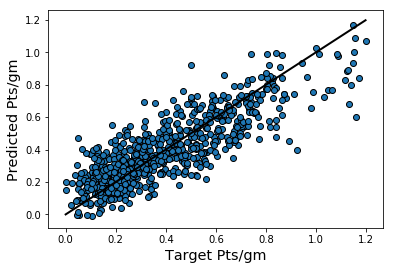

In [16]:
fig, ax = plt.subplots()
ax.scatter(labels_test, labels_predicted, edgecolors=(0, 0, 0))
ax.plot([labels_test.min(), labels_test.max()], [labels_test.min(), labels_test.max()], 'k-', lw=2)
ax.set_xlabel('Target Pts/gm', size='x-large')
ax.set_ylabel('Predicted Pts/gm', size='x-large')
plt.show()

The error appears to be a bit larger for players who have produced at a pace above 1 pts/gm - as these events are relatively uncommon, they are probably underrepresented within the dataset. Otherwise, the predictions seem to follow the "perfect fit" line pretty much as expected, althoug we would always like to see the data more tightly compacted around this line. To improve the accuracy of the model, introducing team statistics in the list of features could potentially represent an attractive approach, as we know that context has a large impact on the production of hockey players. Introducing statistics obtained from video analysis, like the distance skated by players, their proximity to the puck and the location of their shots could also represent relevant data to introduce in the model.

Finally, just for fun, let's predict how many points a player will get during next (2018-2019) season. We can do that by extracting the 2017-2018 features for that given players, and use the trained models to predict the label. Let's do it for Sydney Crosby, and print the result.

In [17]:
#Extract and preprocess the 2017-2018 statistics of Sydney Crosby
player_name = 'Sidney Crosby'
dataframe_index = player_name + '_20172018'
features = df_all_stats.loc[dataframe_index, :].values
features = features[:-1].reshape(1, number_features)
features = scaler_features.transform(features)
label = sess.run(predictions, feed_dict = {x: features})
label = scaler_labels.inverse_transform(label)
print('In the 2017-2018 season', player_name, 'will score', '%.2f' % float(label), 'pts/gm!')

In the 2017-2018 season Sidney Crosby will score 0.98 pts/gm!


According to the model, Sidney Crosby will score 0.98 pts/game next season! We will be able to see a year from now how accurate this is. Note that the prediction will slightly change if we run the script again, because of the random initialization of the neural network weights and bias. Predictions for other players can be obtained simply by changing the "player_name" variable above. Have fun!

In [18]:
sess.close()